# LightGBM Regression sample
### Hold out simple optune tuning

### Import libraries

In [1]:
!pip install shap
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
from tqdm import tqdm

import lightgbm as lgb
import optuna
import shap

### Dataset

In [3]:
# ----------------------------------------------
# Create sample dataset
# ----------------------------------------------

# Dataset
housing = fetch_california_housing()
housing_data = pd.DataFrame(data = housing.data, columns = housing.feature_names)
housing_data['target'] = housing.target
housing_data.reset_index(inplace = True, drop = True)

# Functions
def make_correlation_category(
        x_grid: list,
        y_grid: list,
        x_feature_name: str,
        y_feature_name: str,
        datset: pd.core.frame.DataFrame,
        catefory_names = list('ABCDEFGHIJKLMNOPQLSTUVWXYZ')
):
    i = 0
    index_list = []
    category_list = []
    for y1, y2 in zip(y_grid[:-1], y_grid[1:]):
        for x1, x2 in zip(x_grid[:-1], x_grid[1:]):
            temp_data = datset[(x1<=datset[x_feature_name]) & (datset[x_feature_name]<x2) & (y1<=datset[y_feature_name]) & (datset[y_feature_name]<y2)].copy()
            if temp_data.shape[0] > 0:
                index_list += temp_data.index.tolist()
                category_list += [catefory_names[i] for k in range(temp_data.shape[0])]
                i += 1
    return np.array(category_list)[np.argsort(np.array(index_list))]

# Make categorical features 1
housing_data['Area_category'] = make_correlation_category(
    x_grid = [32, 34, 36, 38, 40, 44],
    y_grid = [-126, -122, -120, -118, -116, -114],
    x_feature_name = 'Latitude',
    y_feature_name = 'Longitude',
    datset = housing_data,
)

# Make categorical features 2
housing_data['Room_num_category'] = make_correlation_category(
    x_grid = [0, 5, 10, 40],
    y_grid = [0, 20, 40, 170],
    x_feature_name = 'AveBedrms',
    y_feature_name = 'AveRooms',
    datset = housing_data,
)

In [4]:
housing_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,Area_category,Room_num_category
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,A,A
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,A,A
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,A,A
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,A,A
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,A,A
...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,F,A
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,F,A
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,F,A
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,F,A


### Train-test split

In [5]:
train_valid_data, test_data = train_test_split(housing_data, test_size=0.2, shuffle=True)
print(f'Train & validation data shape: {train_valid_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train & validation data shape: (16512, 11)
Test data shape: (4128, 11)


### Category encoding

In [6]:
# ----------------------------------------------
# Categorical encoding
# ----------------------------------------------

categorical_featues = ['Area_category', 'Room_num_category']
categorical_encoders = {}
for col in categorical_featues:
    enc = LabelEncoder()
    enc.fit(train_valid_data[col].unique())
    train_valid_data[col+'_encoded'] = enc.transform(train_valid_data[col])
    categorical_encoders[col] = enc

### Tuning LGBM parameters

In [7]:
# ----------------------------------------------
# Hyper parameter tuning by optuna
# ----------------------------------------------

# Feature names
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Area_category_encoded', 'Room_num_category_encoded']
target_name = ['target']

# Fixed paramters
fixed_parameters = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'boosting_type': 'gbdt',
        'verbose': -1
}

# Trial function
def objective(trial):

    # Train-validation split
    X_train, X_valid, y_train, y_valid = train_test_split(train_valid_data[feature_names], train_valid_data[target_name], shuffle = True, test_size = 0.2)

    # Parameters
    tuning_parameters = {
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # Training
    lgb_data_train = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(fixed_parameters|tuning_parameters, lgb_data_train)

    # Validation
    y_pred = model.predict(X_valid)
    RMSE = mean_squared_error(y_true = y_valid.values.ravel(), y_pred = y_pred)
    return RMSE

# Tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2026-01-11 23:01:27,124] A new study created in memory with name: no-name-f2956c0a-28cd-41d5-8c05-b9c5ce3e7d0a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-11 23:01:29,460] Trial 0 finished with value: 0.21668693012131102 and parameters: {'lambda_l1': 0.4197985937948549, 'lambda_l2': 5.77402641889679e-06, 'num_leaves': 57, 'feature_fraction': 0.6279536114911571, 'bagging_fraction': 0.8286419067811062, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 0 with value: 0.21668693012131102.
[I 2026-01-11 23:01:34,087] Trial 1 finished with value: 0.21674187966487043 and parameters: {'lambda_l1': 0.010584647684936103, 'lambda_l2': 3.5219993893022566e-05, 'num_leaves': 221, 'feature_fraction': 0.97334434907571, 'bagging_fraction': 0.7824909181246162, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 0 with value: 0.21668693012131102.
[I 2026-01-11 23:01:35,281] Trial 2 finished with value: 0.2257791460829178 and parameters: {'lambda_l1': 0.000947710403193492, 'lambda_l2': 0.006154853896205305, 'num_leaves': 246, 'feature_fraction': 0.4830954458720085, 'bagging_fraction': 0.5984337383647462, 'bagging_freq': 3, 'min_chi

### Training using best params

In [8]:
# ----------------------------------------------
# Model training using best parameters
# ----------------------------------------------

# Best parameters
best_params = fixed_parameters|study.best_params

# Training
lgb_data_train = lgb.Dataset(train_valid_data[feature_names], label=train_valid_data[target_name])
model = lgb.train(best_params, lgb_data_train)

### Evaluation

In [9]:
# ----------------------------------------------
# Categoty encoding of test dataset
# ----------------------------------------------
for col, enc in categorical_encoders.items():
    test_data[col+'_encoded'] = enc.transform(test_data[col])

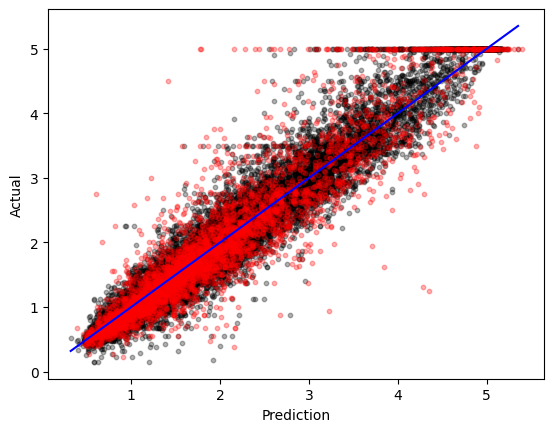

Train RMSE: 0.08723
Test RMSE: 0.19601


In [10]:
# ----------------------------------------------
# Model evaluation by test data
# ----------------------------------------------

# Prediction
y_pred_train = model.predict(train_valid_data[feature_names])
y_pred_test = model.predict(test_data[feature_names])

# Plot
plt.scatter(y_pred_train, train_valid_data[target_name].values.ravel(), s=10, color='k', alpha=0.3)
plt.scatter(y_pred_test, test_data[target_name].values.ravel(), s=10, color='r', alpha=0.3)
plt.plot([y_pred_train.min(), y_pred_train.max()], [y_pred_train.min(), y_pred_train.max()], color='b')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Metrics
RMSE_train = mean_squared_error(y_true = train_valid_data[target_name].values.ravel(), y_pred = y_pred_train)
RMSE_test = mean_squared_error(y_true = test_data[target_name].values.ravel(), y_pred = y_pred_test)
print(f'Train RMSE: {RMSE_train:.5f}')
print(f'Test RMSE: {RMSE_test:.5f}')

### SHAP explanation

In [11]:
# ----------------------------------------------
# Shap value calculation
# ----------------------------------------------
explainer = shap.TreeExplainer(model, data=train_valid_data[feature_names])
shape_values = explainer.shap_values(train_valid_data[feature_names])

100%|===================| 16508/16512 [02:53<00:00]       

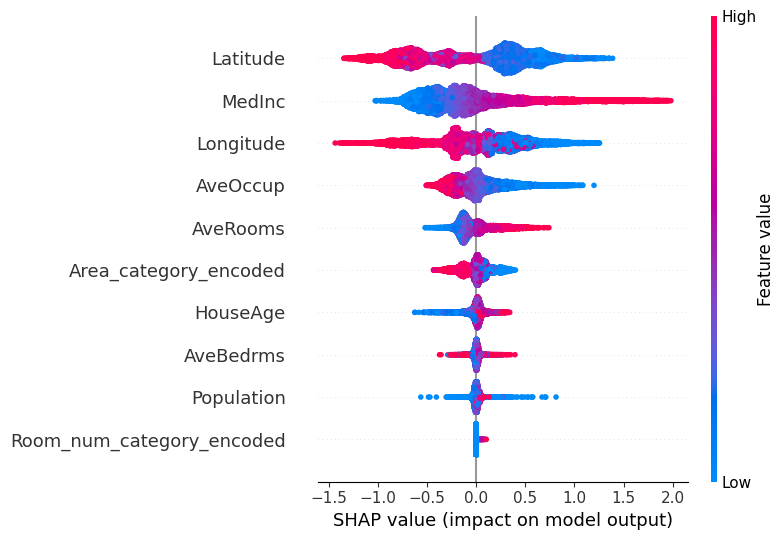

In [12]:
# ----------------------------------------------
# Plot 1
# ----------------------------------------------
shap.summary_plot(
    shap_values=shape_values,
    features=train_valid_data[feature_names],
    feature_names=feature_names
)

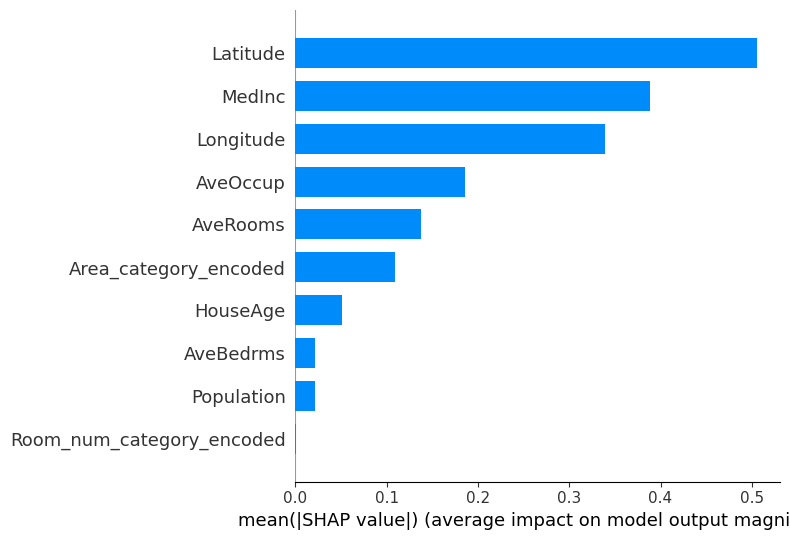

In [13]:
# ----------------------------------------------
# Plot 2
# ----------------------------------------------
shap.summary_plot(
    shap_values=shape_values,
    features=train_valid_data[feature_names],
    feature_names=feature_names,
    plot_type = 'bar'
)

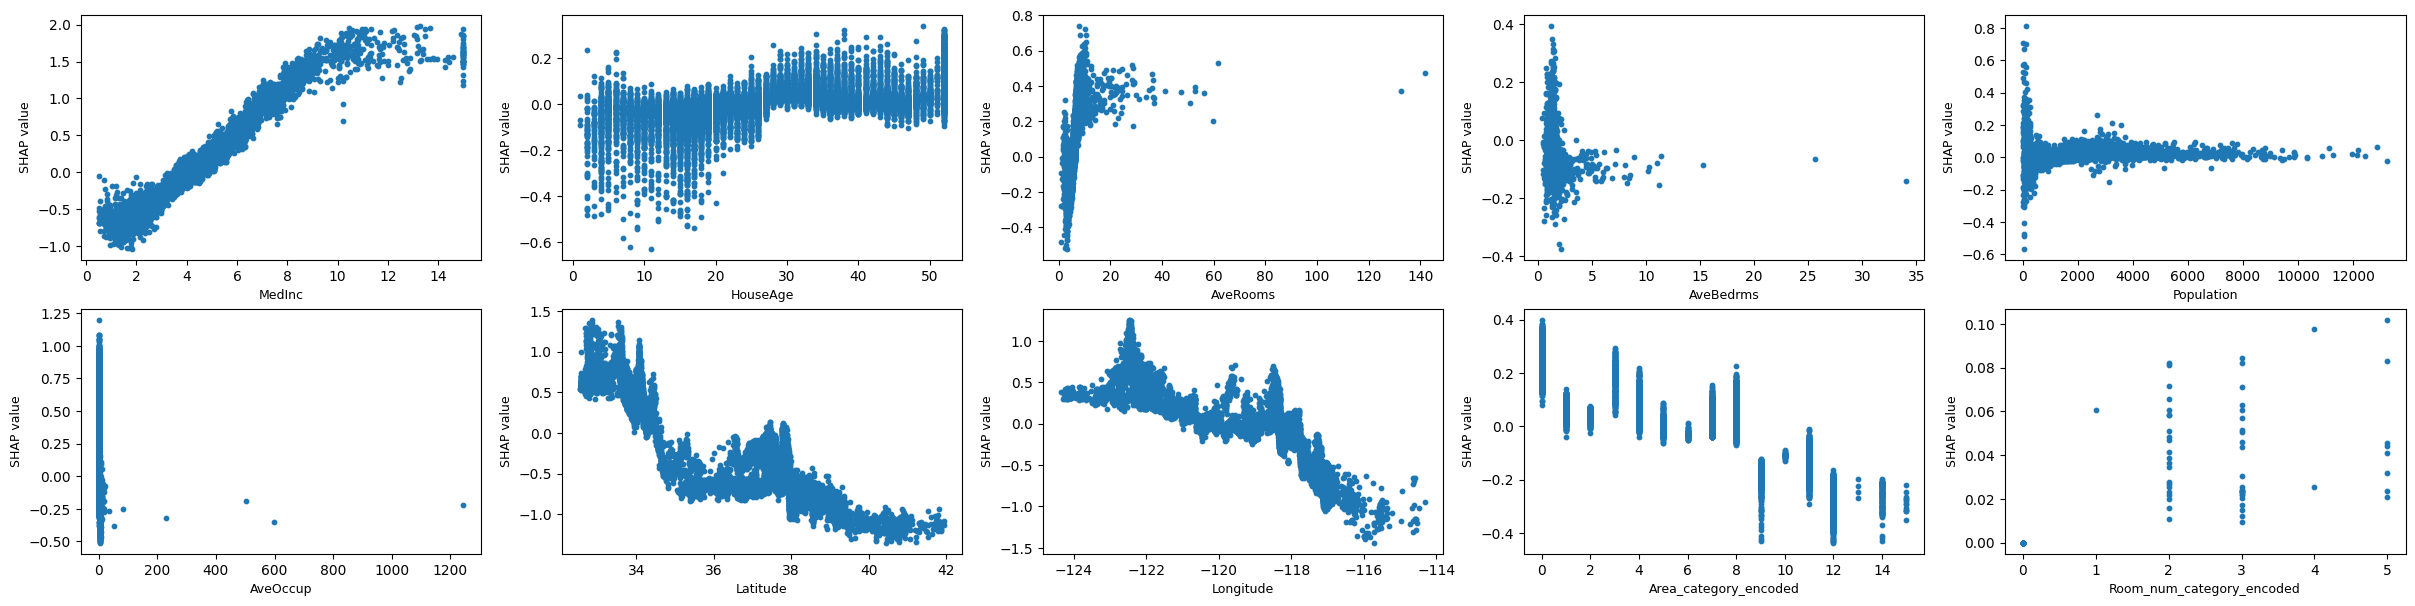

In [14]:
# ----------------------------------------------
# Plot 3
# ----------------------------------------------

fig, ax = plt.subplots(2, 5, figsize = (30, 7))
ax = ax.ravel()
for i, feature_name in enumerate(feature_names):
    ax[i].scatter(train_valid_data[feature_names].values[:,i], shape_values[:,i], s = 10)
    ax[i].set_xlabel(feature_name, fontsize = 9)
    ax[i].set_ylabel('SHAP value', fontsize = 9)